In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess

import BayesianGit.BayesianOptimiser2.BOPackage as BOPackage

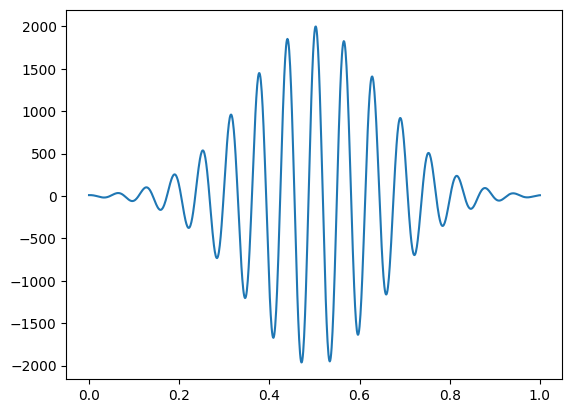

In [87]:
"""
Define the objective function.
"""

def ObjectiveFunction(x):
    x_centre = 0.5
    FWHM = 0.3
    width = FWHM / (2 * np.log(2))

    spatial_intensity =  np.exp(- ((x - x_centre) / width)**2)

    return 2000 * np.cos(100 * x) * spatial_intensity

X = np.linspace(0, 1, 1001, endpoint=True)

plt.plot(X, ObjectiveFunction(X))

In [88]:
"""
Configure the optimiser.
"""
Kernel = BOPackage.RBF_Kernel
length_scale = 0.04

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 2
min_kappa = 1

bounds = np.array([[0, 1]])
dynamic_bounds = True
iterations_between_reducing_bounds = 3
first_reduce_bounds = 5
reduce_bounds_factor = 0.5

n_samples = 10
random_seed = 25

log_path = '/work4/clf/david/Bayesian/Outputs/BO_Test_log_1'

if os.path.exists(log_path):
    subprocess.run(['rm', '-rf', log_path], check=True, text=True, capture_output=True)  


# Create the object
bo = BOPackage.BO(KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  n_samples=n_samples,
                  log_path=log_path,
                  dynamic_bounds=dynamic_bounds,
                  iterations_between_reducing_bounds=iterations_between_reducing_bounds,
                  first_reduce_bounds=first_reduce_bounds,
                  reduce_bounds_factor=reduce_bounds_factor,
                  random_seed=random_seed)

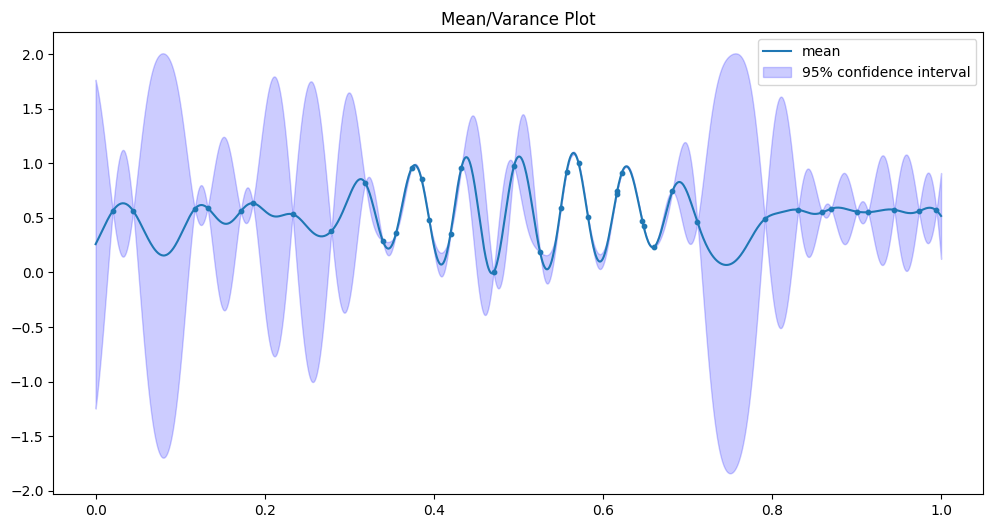

In [89]:
"""
If dynamic_bounds is set to True, the bounds will be reduced by a factor specified (reduce_bounds_factor) and centred around the best datapoint so far.
This will occur when two conditions are simultaneouly met:
1) A minimum number of iterations have occured, corresponding to first_reduce_bounds. An iteration is defined as every time an update data function is used, with the update_iteration parameter set to True.
2) The best value of the objective function has not been improved upon within the last iterations_between_reducing_bounds iterations.

First, we peform 10 iterations, each with a batch size of 4. We see in the sausage plot that X values are sampled throughout the region of the initial bounds: [0,1]
"""

for i in range(10):
    raw_X = bo.GetNextXBatch(batch_size = 4, min_kappa=min_kappa, max_kappa=max_kappa)
    raw_y = ObjectiveFunction(raw_X)
    bo.UpdateData(raw_X, raw_y)

BOPackage.SausagePlot(bo)

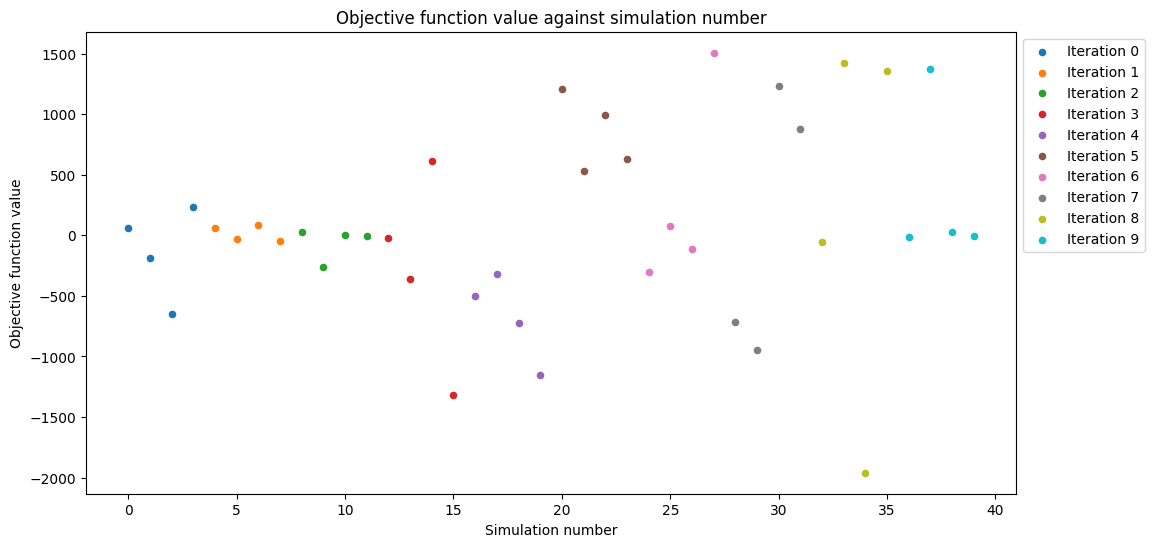

In [90]:
"""
Looking at our results, we see that we first meet the above criteria after iteration 9:
- We are above the minimum number of iterations, 5.
- The iterations_between_reducing_bounds is 3; none of the last 3 iterations (7, 8 and 9) had datapoints with an objective function value higher than the best so far recorded (which happened to be in iteration 6)
"""

BOPackage.PlotData(bo)

In [91]:
"""
Therefore, the bounds will now be reduced. The new bounds will be centred around the best datapoint, shown below, and will have a width of 0.5, specified by the reduce_bounds_factor.
The length scale reduces proportionally to the bounds. This is equivalent to having a new objective function stretched out by a factor 2 (for a bounds reduction of 0.5).
"""

print(f'The current best X value, around which the bounds will be centred is {np.round(bo.X_data[bo.BestData()[0][0]][0],2):.2f}')
print(f'The new bounds are {bo.bounds[0]}')

The current best X value, around which the bounds will be centred is 0.57
The new bounds are [0.32122901 0.82122901]


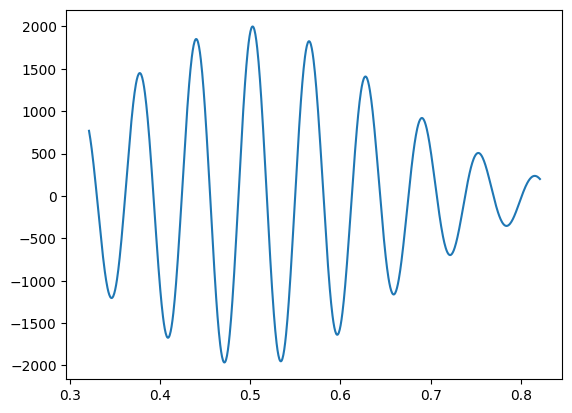

In [92]:
"""
Having reduced the bounds, we can only sample points from the below region of the objective function:
"""

X = np.linspace(bo.bounds[0,0], bo.bounds[0,1], 1001, endpoint=True)

plt.plot(X, ObjectiveFunction(X))



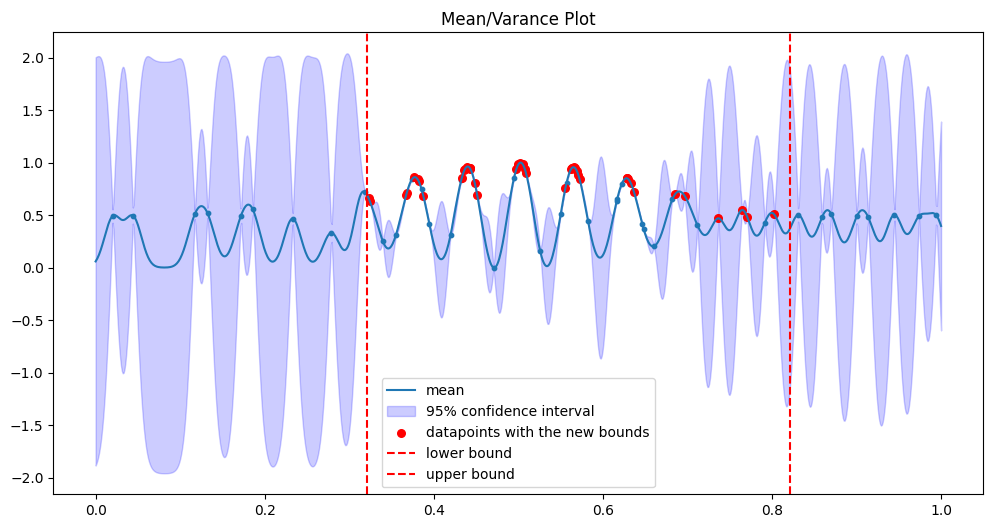

In [93]:
"""
We repeat the process for another 11 iterations, again each with a batch size of four.
Now, it is clear that only points within the new bounds are being sampled.
"""

lower_bound = bo.bounds[0,0]
upper_bound = bo.bounds[0,1]

for i in range(11):
    raw_X = bo.GetNextXBatch(batch_size = 4, min_kappa=min_kappa, max_kappa=max_kappa)
    raw_y = ObjectiveFunction(raw_X)
    bo.UpdateData(raw_X, raw_y)

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

shifted_y_data = bo.y_data - np.min(bo.y_data)
normalized_y_data = shifted_y_data / np.max(shifted_y_data)

plt.scatter(bo.X_data, normalized_y_data, s=10)

plt.scatter(bo.X_data[-44:], normalized_y_data[-44:], s=30, color='red', label=f'datapoints with the new bounds')

plt.axvline(x=lower_bound, color='red', linestyle='--', label='lower bound')
plt.axvline(x=upper_bound, color='red', linestyle='--', label='upper bound')


plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()

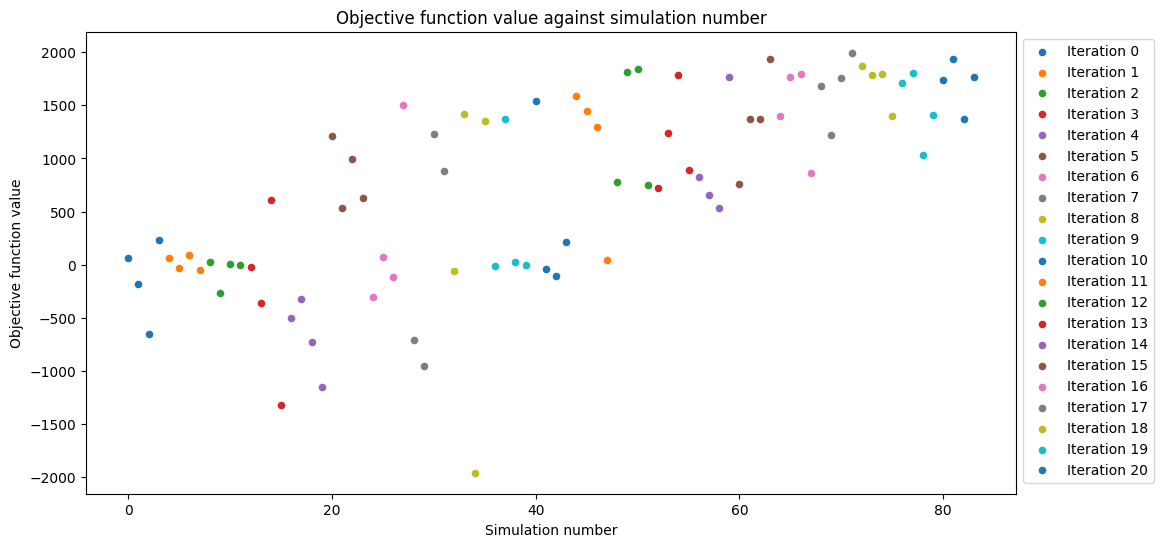

In [94]:
"""
Looking at our results, we see that we next meet the criteria for reducing the bounds after iteration 20:
"""

BOPackage.PlotData(bo)

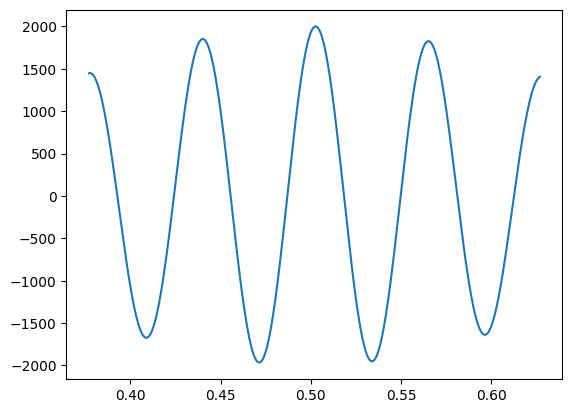

In [95]:
"""
We will now go through one final example of reducing the bounds

We are reduced to the below region of our obejective function:
"""

X = np.linspace(bo.bounds[0,0], bo.bounds[0,1], 1001, endpoint=True)

plt.plot(X, ObjectiveFunction(X))

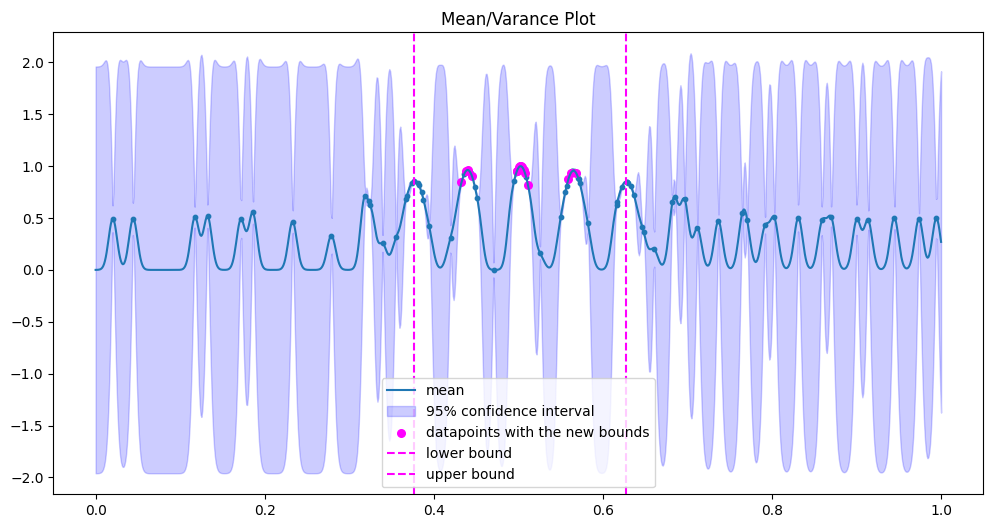

In [96]:
"""
The next time the criteria will be met will be after iteration 24.
So, we perform another 4 iterations.
"""

lower_bound = bo.bounds[0,0]
upper_bound = bo.bounds[0,1]

for i in range(4):
    raw_X = bo.GetNextXBatch(batch_size = 4, min_kappa=min_kappa, max_kappa=max_kappa)
    raw_y = ObjectiveFunction(raw_X)
    bo.UpdateData(raw_X, raw_y)

plt.figure(figsize=(12, 6))

sample_points = np.linspace(0, 1, 1000, endpoint=True).reshape(1000,1)

mean, variance = bo.PredictMeanVariance(sample_points)

plt.plot(sample_points, mean, label='mean')
plt.fill_between(sample_points[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

shifted_y_data = bo.y_data - np.min(bo.y_data)
normalized_y_data = shifted_y_data / np.max(shifted_y_data)

plt.scatter(bo.X_data, normalized_y_data, s=10)

plt.scatter(bo.X_data[-16:], normalized_y_data[-16:], s=30, color='magenta', label=f'datapoints with the new bounds')

plt.axvline(x=lower_bound, color='magenta', linestyle='--', label='lower bound')
plt.axvline(x=upper_bound, color='magenta', linestyle='--', label='upper bound')


plt.title("Mean/Varance Plot")

plt.legend()

# Display the plot
plt.show()

In [97]:
"""
At this point, the bounds would be reduced again and the cycle would continue.
"""

'\nAt this point, the bounds would be reduced again and the cycle would continue.\n'